# Cyclical data analysis with FFT

In [209]:
!pip install matplotlib scipy nitime
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from scipy import signal, interpolate
import nitime.algorithms as tsa
import warnings
warnings.simplefilter('ignore')

## Download data 
Petit et al. (1999, Nature)  
https://doi.org/10.1038/20859  
https://doi.org/10.1594/PANGAEA.55505  
https://doi.pangaea.de/10.1594/PANGAEA.55505?format=textfile

In [210]:
url = 'https://doi.pangaea.de/10.1594/PANGAEA.55505?format=textfile'
filename = './Vostok_Deut_dT.txt'
urllib.request.urlretrieve(url, filename)
f = open(filename, 'r')
tmp = f.read()
f.close()
for i in range(29):
    print(tmp.split('\n')[i])
print(':')

/* DATA DESCRIPTION:
Citation:	Petit, Jean-Robert; Jouzel, Jean (1999): Vostok ice core deuterium data for 420,000 years. PANGAEA, https://doi.org/10.1594/PANGAEA.55505
Related to:	Petit, Jean-Robert; Jouzel, Jean; Raynaud, Dominique; Barkov, N I; Barnola, Jean-Marc; Basile, Isabelle; Bender, Michael L; Chappellaz, Jérôme A; Davis, John C; Delaygue, Gilles; Delmotte, M; Kotlyakov, Vladimir; Legrand, Michel R; Lipenkov, Vladimir Ya; Lorius, C; Pepin, L; Ritz, Catherine; Saltzman, Eric S; Stiévenard, Michel (1999): Climate and atmospheric history of the past 420,000 years from the Vostok ice core, Antarctica. Nature, 399(6735), 429-436, https://doi.org/10.1038/20859
Coverage:	LATITUDE: -78.464420 * LONGITUDE: 106.837320
	DATE/TIME START: 1980-01-01T00:00:00 * DATE/TIME END: 1980-01-01T00:00:00
	MINIMUM DEPTH, ice/snow: 0 m * MAXIMUM DEPTH, ice/snow: 3310 m
Event(s):	Vostok * LATITUDE: -78.464420 * LONGITUDE: 106.837320 * DATE/TIME: 1980-01-01T00:00:00 * ELEVATION: 3488.0 m * Recovery: 27

## Load data

In [211]:
dataframe = np.loadtxt('Vostok_Deut_dT.txt', skiprows=17)
dep = dataframe[:,0]
age = dataframe[:,1] * 1e3
isor = dataframe[:,2]
temp = dataframe[:,3]

## Data check

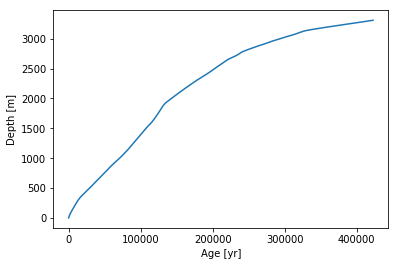

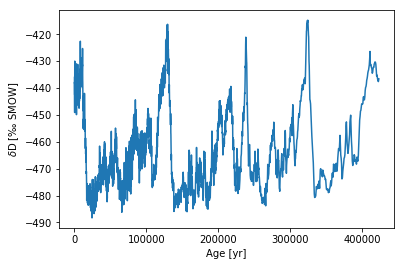

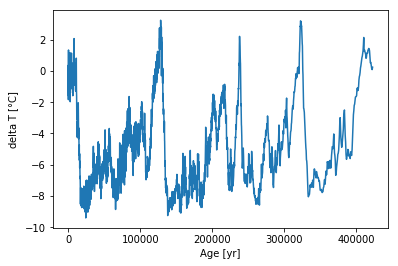

In [212]:
plt.plot(age, dep)
plt.xlabel('Age [yr]')
plt.ylabel('Depth [m]')
plt.show()

plt.plot(age, isor)
plt.xlabel('Age [yr]')
plt.ylabel(r'$\delta$D [‰ SMOW]')
plt.show()

plt.plot(age, temp)
plt.xlabel('Age [yr]')
plt.ylabel('delta T [$\degree$C]')
plt.show()

## Interpolation
Interpolate irregular time series (`age`, `isor`) 

0.23653510452590798 4.22770227702277


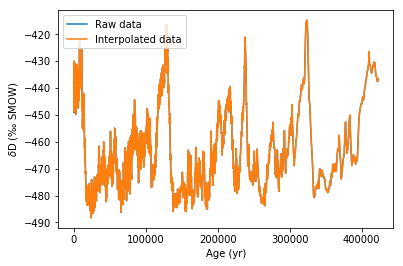

In [213]:
plt.plot(age, isor, label='Raw data')

tmp = interpolate.interp1d(age, isor)
age_interp = np.linspace(min(age), max(age), 100000)
isor_interp = tmp(age_interp)
sampling_rate = abs(age_interp[2]-age_interp[3])
sampling_freq = 1/sampling_rate
print(sampling_freq, sampling_rate)
plt.plot(age_interp, isor_interp, label='Interpolated data')
plt.xlabel('Age (yr)')
plt.ylabel(r'$\delta$D (‰ SMOW)')
plt.legend()
plt.show()

## FFT with several tapering windows

In [214]:
NFFT = len(isor_interp)
df = sampling_rate
tukeywindow = signal.tukey(NFFT)
blackmantukeywindow = signal.blackman(NFFT)
freq = np.fft.rfftfreq(NFFT, df)
spec = np.fft.rfft(isor_interp[0:NFFT], NFFT)
specTukey = np.fft.rfft(isor_interp[0:NFFT]*tukeywindow, NFFT)
specBlackmanTukey = np.fft.rfft(isor_interp[0:NFFT]*blackmantukeywindow, NFFT)
freqMTM, specMTM, _ = tsa.multi_taper_psd(isor_interp[0:NFFT], 1/df)
print('done')

done


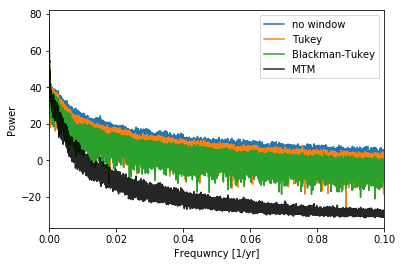

In [217]:
plt.plot(freq, 10*np.log10(abs(spec)), label='no window')
plt.plot(freq, 10*np.log10(abs(specTukey)), label='Tukey')
plt.plot(freq, 10*np.log10(abs(specBlackmanTukey)), label='Blackman-Tukey')
plt.plot(freqMTM, 10*np.log10(specMTM), label="MTM", color='k', alpha=0.85)

plt.legend(loc='upper right')
plt.xlabel('Frequwncy [1/yr]')
plt.ylabel('Power')

plt.xlim(0, 0.1)
plt.show()

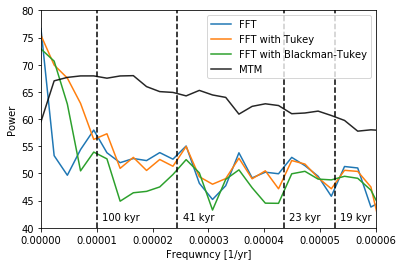

In [218]:
plt.plot(freq, 10*np.log10(abs(spec)), label='FFT')
plt.plot(freq, 10*np.log10(abs(specTukey)), label='FFT with Tukey')
plt.plot(freq, 10*np.log10(abs(specBlackmanTukey)), label='FFT with Blackman-Tukey')
plt.plot(freqMTM, 10*np.log10(specMTM), label="MTM", color='k', alpha=0.85)

reffreq = [1/(19*1e3), 1/(23*1e3), 1/(41*1e3), 1/(100*1e3)]
for i in range(len(reffreq)):
    plt.axvline(reffreq[i], color='k', linestyle='--')
    plt.text(reffreq[i]+1e-6, 41, str('{:.0f}'.format(1/reffreq[i]*1e-3))+' kyr', va='bottom', ha='left')

plt.legend(loc='upper right')
plt.xlabel('Frequwncy [1/yr]')
plt.ylabel('Power')
plt.xlim(0, 6*1e-5)
plt.ylim(40, 80)

plt.show()

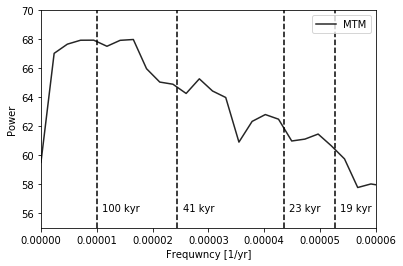

In [219]:
plt.plot(freqMTM, 10*np.log10(specMTM), label="MTM", color='k', alpha=0.85)

reffreq = [1/(19*1e3), 1/(23*1e3), 1/(41*1e3), 1/(100*1e3)]
for i in range(len(reffreq)):
    plt.axvline(reffreq[i], color='k', linestyle='--')
    plt.text(reffreq[i]+1e-6, 56, str('{:.0f}'.format(1/reffreq[i]*1e-3))+' kyr', va='bottom', ha='left')

plt.legend(loc='upper right')
plt.xlabel('Frequwncy [1/yr]')
plt.ylabel('Power')
plt.xlim(0, 6*1e-5)
plt.ylim(55, 70)
plt.show()